<h1> Batch Dimensions and Visualization </h1>

0 : torch.Size([5, 300, 64, 64])
1 : torch.Size([5, 300, 64, 64])
2 : torch.Size([5, 300, 64, 64])
3 : torch.Size([5, 300, 64, 64])
4 : torch.Size([5, 300, 64, 64])
5 : torch.Size([5, 300, 64, 64])
6 : torch.Size([5, 300, 64, 64])
7 : torch.Size([5, 300, 64, 64])
8 : torch.Size([5, 300, 64, 64])
9 : torch.Size([5, 300, 64, 64])
10 : torch.Size([5, 300, 64, 64])
11 : torch.Size([5, 300, 64, 64])
12 : torch.Size([5, 300, 64, 64])
13 : torch.Size([5, 300, 64, 64])
14 : torch.Size([5, 300, 64, 64])
15 : torch.Size([5, 300, 64, 64])
16 : torch.Size([5, 300, 64, 64])
17 : torch.Size([5, 300, 64, 64])
18 : torch.Size([5, 300, 64, 64])
19 : torch.Size([5, 300, 64, 64])
20 : torch.Size([5, 300, 64, 64])
21 : torch.Size([5, 300, 64, 64])
22 : torch.Size([5, 300, 64, 64])
23 : torch.Size([5, 300, 64, 64])
24 : torch.Size([5, 300, 64, 64])
25 : torch.Size([5, 300, 64, 64])
26 : torch.Size([5, 300, 64, 64])
27 : torch.Size([5, 300, 64, 64])
28 : torch.Size([5, 300, 64, 64])
29 : torch.Size([5, 300,

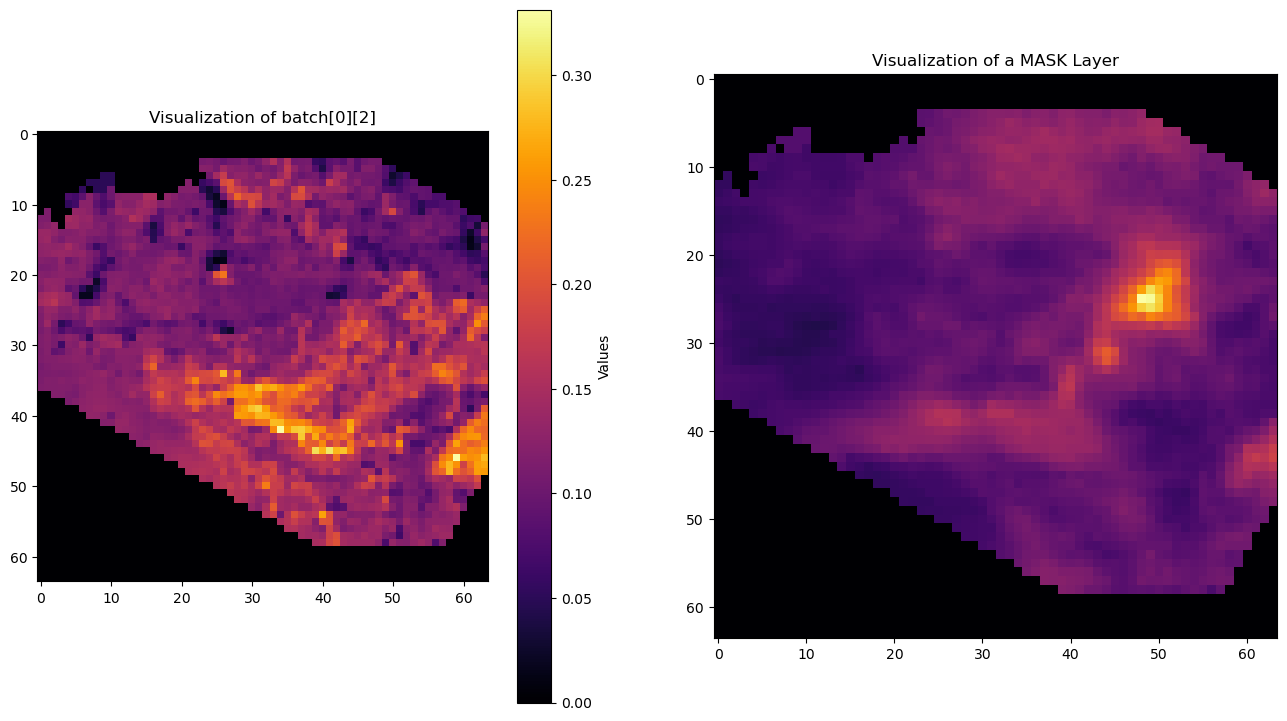

In [2]:
import matplotlib.pyplot as plt
import torch
from utils import TrajectoryDataset
from torch.utils.data import DataLoader
from pathlib import Path

PATH = Path('.')
window= 10
batch_size = 5


trainset = TrajectoryDataset(PATH / 'data/train.h5', window=window, flatten=True)
validset = TrajectoryDataset(PATH / 'data/valid.h5', window=window, flatten=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)

plot_batch = None
for i, (batch, _) in  enumerate(trainloader):
    print(f"{i} : {batch.shape}")
    plot_batch = batch



# Plot
# Choose random batch[i,j, :, :]
i = torch.randint(0,1,(1,))
j = torch.randint(0,10, (1,))
if (j+1) % 4 == 0 and j != 0:
    j = j -1

figure, axis = plt.subplots(1,2, figsize=(16,9))
im = axis[0].imshow(batch[i[0],j[0]],  cmap='inferno')
axis[0].set_title(f"Visualization of batch[{i[0]}][{j[0]}]")
figure.colorbar(mappable = im,label='Values')
axis[1].imshow(batch[0,7],  cmap='inferno')
axis[1].set_title(f"Visualization of a MASK Layer")

plt.show()


<h1> Understand UNET dimensions </h1>

In [1]:

import torch
import torch.nn as nn
from nn import UNet

in_channels = 4
out_channels = 4
mod_features = 66
hidden_channels = [32, 64, 128]
hidden_blocks = [2, 3, 5]
spatial = 2

# UNET Forward : x (B, C, H, W)
unet = UNet(
    in_channels=in_channels,
    out_channels=out_channels,
    mod_features=mod_features,
    hidden_channels=hidden_channels,
    hidden_blocks=hidden_blocks,
    spatial=spatial,
)


batch_size = 4
x = torch.randn(batch_size, in_channels, 128, 128)


y = torch.randn(batch_size, mod_features)


output = unet(x, y)


print(output.shape)

torch.Size([4, 4, 128, 128])


<h1> Understand ScoreUNET dimensions </h1>

In [15]:
import torch
import torch.nn as nn
from score import ScoreUNet
batch_size = 5
MAR_channels = 4 # Example ['RF', 'T2m', 'U10m', MASK]
window = 10
y_dim = 128
x_dim = 128

CONFIG = { 'hidden_channels' : [32, 64, 128],  \
'hidden_blocks' : [2, 3, 5],  \
'spatial' : 2, \
'channels' : window*MAR_channels, \
'context' : 0,\
'embedding' : 64 }


score_unet = ScoreUNet(**CONFIG)




x = torch.randn([batch_size, window*MAR_channels, y_dim, x_dim]) # because of flatten
t = torch.rand(x.shape[0], dtype=x.dtype, device=x.device)

print(f"x:  {x.shape} , t: {t.shape}")
c = None


output = score_unet(x, t, c)


print(f"Output Shape : {output.shape}")

x:  torch.Size([5, 40, 128, 128]) , t: torch.Size([5])
Output Shape : torch.Size([5, 40, 128, 128])


<h1> Understand VPSDE dimensions </h1>

In [16]:
import torch
import torch.nn as nn
from score import ScoreUNet, VPSDE

batch_size = 5
MAR_channels = 4 # Example ['RF', 'T2m', 'U10m', MASK]
window = 10
y_dim = 128
x_dim = 128

CONFIG = { 'hidden_channels' : [32, 64, 128],  \
'hidden_blocks' : [2, 3, 5],  \
'spatial' : 2, \
'channels' : window*MAR_channels, \
'context' : 0,\
'embedding' : 64,\
}


score_unet = ScoreUNet(**CONFIG)
vpsde = VPSDE(score_unet, shape=(MAR_channels*window, y_dim, x_dim))



x = torch.randn([batch_size, window*MAR_channels, y_dim, x_dim]) # window*MAR_channels because of flatten

vpsde.loss(x)

tensor(1.2994, grad_fn=<MeanBackward0>)

<h1> Batch Loop (Ensure Architecture design is well shaped)</h1>

In [17]:
import torch
import h5py
import torch.nn as nn
from score import ScoreUNet, VPSDE

# Common dimensions
batch_size = 5
MAR_channels = 4 # Example ['RF', 'T2m', 'U10m', MASK]
window = 10
y_dim = 128
x_dim = 128

# Define the network
CONFIG = { 'hidden_channels' : [32, 64, 128],  \
'hidden_blocks' : [2, 3, 5],  \
'spatial' : 2, \
'channels' : window*MAR_channels, \
'context' : 0,\
'embedding' : 64 }

# Denoiser and Scheduler
score_unet = ScoreUNet(**CONFIG)
vpsde = VPSDE(score_unet, shape=(MAR_channels*window, y_dim, x_dim))

trainset = TrajectoryDataset(PATH / "data/train.h5", window=10, flatten=True)
validset = TrajectoryDataset(PATH / "data/valid.h5", window=10, flatten=True)

'''
 Batch loop
'''
with h5py.File(PATH / "data/mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32).unsqueeze(0)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=1, persistent_workers=True)
for i, (batch, _) in enumerate(trainloader):
        loss = vpsde.loss(batch, w=mask)
        print(f"{i} batch : {batch.shape}, loss : {loss}")

0 batch : torch.Size([5, 40, 64, 64]), loss : 1.2517942190170288
1 batch : torch.Size([5, 40, 64, 64]), loss : 1.2469114065170288
2 batch : torch.Size([5, 40, 64, 64]), loss : 1.2365354299545288
3 batch : torch.Size([5, 40, 64, 64]), loss : 1.2249854803085327
4 batch : torch.Size([4, 40, 64, 64]), loss : 1.2477240562438965


<h1> CPU Training Loop </h1>

In [ ]:
import os
import h5py
import math
import torch
import numpy as np
import wandb
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import trange
from pathlib import Path
from utils import SequenceDataset
from score import ScoreUNet, MCScoreWrapper, VPSDE
from score import VPSDE

PATH = Path('.')

with h5py.File(PATH / "data/mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32).unsqueeze(0)

if torch.isnan(mask).any():
    raise ValueError("Mask contains NaN values!")

TRAIN_CONFIG = {
    "epochs": 100,
    "batch_size": 5,
    "learning_rate": 1e-3,
    "weight_decay": 1e-3,
    "scheduler": "linear",
    "embedding": 32,
    "hidden_channels": (64,),
    "hidden_blocks": (3,),
    "activation": "SiLU",
}
device = 'cpu'

'''
Definition of Denoiser and Scheduler
'''
# Common dimensions
batch_size = 30
MAR_channels = 2 # Example ['RF', 'T2m', 'U10m', MASK]
window = 12
y_dim = 64
x_dim = 64

MODEL_CONFIG = { 'hidden_channels' : [32, 64, 128],  \
'hidden_blocks' : [2, 3, 5],  \
'spatial' : 2, \
'channels' : window*MAR_channels, \
'context' : 0,\
'embedding' : 64 }

CONFIG = {**TRAIN_CONFIG, **MODEL_CONFIG}
run = wandb.init(
    project="Denoiser-Training",
    config= CONFIG)


# Denoiser and Scheduler
score_unet = ScoreUNet(**MODEL_CONFIG)
vpsde = VPSDE(score_unet, shape=(MAR_channels*window, y_dim, x_dim))

# Load Dataset
trainset = SequenceDataset(PATH / "data/train.h5", window=window, flatten=True)
validset = SequenceDataset(PATH / "data/test.h5", window=window, flatten=True)

trainloader = DataLoader(trainset, batch_size=TRAIN_CONFIG["batch_size"], shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=TRAIN_CONFIG["batch_size"], shuffle=False, num_workers=1, persistent_workers=True)


optimizer = optim.AdamW(vpsde.parameters(), lr=TRAIN_CONFIG["learning_rate"], weight_decay=TRAIN_CONFIG["weight_decay"])

# Define Learning Rate Scheduler
if TRAIN_CONFIG["scheduler"] == "linear":
    lr_lambda = lambda t: 1 - (t / TRAIN_CONFIG["epochs"])
elif TRAIN_CONFIG["scheduler"] == "cosine":
    lr_lambda = lambda t: (1 + math.cos(math.pi * t / TRAIN_CONFIG["epochs"])) / 2
elif TRAIN_CONFIG["scheduler"] == "exponential":
    lr_lambda = lambda t: math.exp(-7 * (t / TRAIN_CONFIG["epochs"]) ** 2)
else:
    raise ValueError("Invalid scheduler type")

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

all_losses_train = []
all_losses_valid = []
for epoch in (bar := trange(TRAIN_CONFIG["epochs"], ncols=88)):
    losses_train = []
    losses_valid = []

    # Training
    vpsde.train()
    for i, (batch, _) in enumerate(trainloader):
        if torch.isnan(batch).any():
            raise ValueError("batch contains NaN values!")
        batch = batch.to(device)
        optimizer.zero_grad()

        # Mask
        mask_batch = mask.to(device).expand_as(batch)
        w = mask_batch.float()


        loss = vpsde.loss(batch, w=w)
        loss.backward()
        optimizer.step()

        losses_train.append(loss.detach())

    # Evaluation
    vpsde.eval()
    with torch.no_grad():
        for batch, _ in validloader:
            batch = batch.to(device)
            mask_batch = mask.to(device).expand_as(batch)
            w = mask_batch.float()

            loss = vpsde.loss(batch, w=w)
            losses_valid.append(loss)

    loss_train = torch.stack(losses_train).mean().item()
    loss_valid = torch.stack(losses_valid).mean().item()
    print(f"Train Loss : {loss_train}, Valid Loss : {loss_valid}")
    lr = optimizer.param_groups[0]['lr']
    wandb.log({"Train Loss" : loss_train, "Valid Loss" : loss_valid, "lr" : lr})
    all_losses_train.append(loss_train)
    all_losses_valid.append(loss_valid)

    scheduler.step()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: maximetemoschenko (maximetemoschenko-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


  1%|▍                                              | 1/100 [11:45<19:23:21, 705.07s/it]

Train Loss : 0.16507048904895782, Valid Loss : 0.08321784436702728


  2%|▉                                              | 2/100 [23:34<19:15:43, 707.59s/it]

Train Loss : 0.07513754814863205, Valid Loss : 0.0738292932510376


  3%|█▍                                             | 3/100 [35:03<18:50:29, 699.27s/it]

Train Loss : 0.06775123625993729, Valid Loss : 0.06914680451154709


  4%|█▉                                             | 4/100 [46:30<18:30:44, 694.22s/it]

Train Loss : 0.06351489573717117, Valid Loss : 0.058503881096839905


  5%|██▎                                            | 5/100 [57:46<18:08:40, 687.58s/it]

Train Loss : 0.05676239728927612, Valid Loss : 0.0544181689620018


  6%|██▋                                          | 6/100 [1:09:00<17:49:58, 682.96s/it]

Train Loss : 0.052769992500543594, Valid Loss : 0.05280452221632004


  7%|███▏                                         | 7/100 [1:20:50<17:52:21, 691.85s/it]

Train Loss : 0.052800726145505905, Valid Loss : 0.05458290874958038


  8%|███▌                                         | 8/100 [1:32:22<17:41:14, 692.12s/it]

Train Loss : 0.049385812133550644, Valid Loss : 0.04931151494383812


  9%|████                                         | 9/100 [1:44:10<17:37:11, 697.05s/it]

Train Loss : 0.047378089278936386, Valid Loss : 0.048936981707811356


 10%|████▍                                       | 10/100 [1:55:46<17:25:02, 696.70s/it]

Train Loss : 0.04762216657400131, Valid Loss : 0.04668865352869034


 11%|████▊                                       | 11/100 [2:07:58<17:29:10, 707.31s/it]

Train Loss : 0.045632023364305496, Valid Loss : 0.047235216945409775


 12%|█████▎                                      | 12/100 [2:19:48<17:18:53, 708.33s/it]

Train Loss : 0.048536792397499084, Valid Loss : 0.05029401555657387


 13%|█████▋                                      | 13/100 [2:31:35<17:06:21, 707.83s/it]

Train Loss : 0.04591602459549904, Valid Loss : 0.04756378009915352


 14%|██████▏                                     | 14/100 [2:43:32<16:58:43, 710.74s/it]

Train Loss : 0.046554483473300934, Valid Loss : 0.045975349843502045


 15%|██████▌                                     | 15/100 [2:54:24<16:21:39, 692.93s/it]

Train Loss : 0.042621564120054245, Valid Loss : 0.04656810313463211


 16%|███████                                     | 16/100 [3:05:10<15:50:25, 678.87s/it]

Train Loss : 0.043454524129629135, Valid Loss : 0.04502851516008377


 17%|███████▍                                    | 17/100 [3:15:58<15:25:56, 669.35s/it]

Train Loss : 0.04466931149363518, Valid Loss : 0.04540649428963661


 18%|███████▉                                    | 18/100 [3:27:03<15:13:20, 668.30s/it]

Train Loss : 0.04189338907599449, Valid Loss : 0.0431278832256794


 19%|████████▎                                   | 19/100 [3:38:08<15:00:50, 667.29s/it]

Train Loss : 0.04363381862640381, Valid Loss : 0.04191410541534424


 20%|████████▊                                   | 20/100 [3:50:55<15:29:32, 697.16s/it]

Train Loss : 0.04421737417578697, Valid Loss : 0.04387398436665535


 21%|█████████▏                                  | 21/100 [4:02:39<15:20:42, 699.27s/it]

Train Loss : 0.04190685972571373, Valid Loss : 0.040822584182024


 22%|█████████▋                                  | 22/100 [4:13:55<14:59:55, 692.25s/it]

Train Loss : 0.04316597059369087, Valid Loss : 0.043615031987428665


 23%|██████████                                  | 23/100 [4:25:32<14:50:20, 693.77s/it]

Train Loss : 0.041117649525403976, Valid Loss : 0.04174957424402237


 24%|██████████▌                                 | 24/100 [4:36:45<14:30:50, 687.51s/it]

Train Loss : 0.0431801900267601, Valid Loss : 0.04206399992108345


 25%|███████████                                 | 25/100 [4:48:25<14:24:01, 691.22s/it]

Train Loss : 0.03997907415032387, Valid Loss : 0.04187668859958649


 26%|███████████▍                                | 26/100 [4:59:42<14:07:10, 686.90s/it]

Train Loss : 0.040351465344429016, Valid Loss : 0.04386770352721214


 27%|███████████▉                                | 27/100 [5:11:06<13:54:38, 686.01s/it]

Train Loss : 0.041152238845825195, Valid Loss : 0.04072453826665878


 28%|████████████▎                               | 28/100 [5:22:32<13:43:09, 685.97s/it]

Train Loss : 0.04182692989706993, Valid Loss : 0.04120680317282677


 29%|████████████▊                               | 29/100 [5:34:53<13:51:16, 702.49s/it]

Train Loss : 0.04305804520845413, Valid Loss : 0.04631144925951958


 30%|█████████████▏                              | 30/100 [5:46:35<13:39:36, 702.52s/it]

Train Loss : 0.03827600181102753, Valid Loss : 0.04133784398436546


 31%|█████████████▋                              | 31/100 [5:57:58<13:20:55, 696.46s/it]

Train Loss : 0.03890899196267128, Valid Loss : 0.052568528801202774


 32%|██████████████                              | 32/100 [6:08:52<12:54:49, 683.66s/it]

Train Loss : 0.03988238051533699, Valid Loss : 0.04103761538863182


 33%|██████████████▌                             | 33/100 [6:19:57<12:37:14, 678.12s/it]

Train Loss : 0.03923150897026062, Valid Loss : 0.041215118020772934


 34%|██████████████▉                             | 34/100 [6:31:13<12:25:14, 677.50s/it]

Train Loss : 0.041178587824106216, Valid Loss : 0.041063446551561356


 35%|███████████████▍                            | 35/100 [6:42:46<12:18:56, 682.09s/it]

Train Loss : 0.039860282093286514, Valid Loss : 0.040924958884716034


 36%|███████████████▊                            | 36/100 [6:54:16<12:10:17, 684.65s/it]

Train Loss : 0.041469622403383255, Valid Loss : 0.04009104147553444


 37%|████████████████▎                           | 37/100 [7:05:38<11:58:01, 683.83s/it]

Train Loss : 0.04164645075798035, Valid Loss : 0.039128147065639496


 38%|████████████████▋                           | 38/100 [7:17:05<11:47:24, 684.59s/it]

Train Loss : 0.0378439761698246, Valid Loss : 0.044132549315690994


 39%|█████████████████▏                          | 39/100 [7:28:33<11:37:02, 685.61s/it]

Train Loss : 0.03924432396888733, Valid Loss : 0.03861412778496742


 40%|█████████████████▌                          | 40/100 [7:39:49<11:22:47, 682.79s/it]

Train Loss : 0.040736082941293716, Valid Loss : 0.03986037150025368


 41%|██████████████████                          | 41/100 [7:50:55<11:06:36, 677.90s/it]

Train Loss : 0.04041498526930809, Valid Loss : 0.03989219292998314


 42%|██████████████████▍                         | 42/100 [8:01:56<10:50:14, 672.67s/it]

Train Loss : 0.04014969617128372, Valid Loss : 0.039212316274642944


 43%|██████████████████▉                         | 43/100 [8:13:25<10:43:38, 677.52s/it]

Train Loss : 0.03877004235982895, Valid Loss : 0.040858879685401917


 44%|███████████████████▎                        | 44/100 [8:24:57<10:36:29, 681.96s/it]

Train Loss : 0.039614297449588776, Valid Loss : 0.03796130418777466


 45%|███████████████████▊                        | 45/100 [8:36:29<10:27:51, 684.94s/it]

Train Loss : 0.03984260931611061, Valid Loss : 0.04112599790096283


 46%|████████████████████▏                       | 46/100 [8:47:53<10:16:07, 684.58s/it]

Train Loss : 0.036839552223682404, Valid Loss : 0.04025435820221901


 47%|████████████████████▋                       | 47/100 [8:59:20<10:05:22, 685.32s/it]

Train Loss : 0.03901435807347298, Valid Loss : 0.03791208192706108


 48%|█████████████████████▌                       | 48/100 [9:10:30<9:50:06, 680.90s/it]

Train Loss : 0.036980003118515015, Valid Loss : 0.03931787237524986


 49%|██████████████████████                       | 49/100 [9:21:28<9:32:48, 673.88s/it]

Train Loss : 0.040179599076509476, Valid Loss : 0.041021328419446945


 50%|██████████████████████▌                      | 50/100 [9:32:29<9:18:27, 670.15s/it]

Train Loss : 0.03946249559521675, Valid Loss : 0.04538380354642868


 51%|██████████████████████▉                      | 51/100 [9:43:45<9:08:47, 671.98s/it]

Train Loss : 0.037767183035612106, Valid Loss : 0.039730533957481384


 52%|███████████████████████▍                     | 52/100 [9:55:08<9:00:03, 675.08s/it]

Train Loss : 0.037779949605464935, Valid Loss : 0.04030149057507515


 53%|███████████████████████▎                    | 53/100 [10:06:09<8:45:31, 670.89s/it]

Train Loss : 0.037178535014390945, Valid Loss : 0.038412775844335556


 54%|███████████████████████▊                    | 54/100 [10:17:11<8:32:21, 668.29s/it]

Train Loss : 0.038131020963191986, Valid Loss : 0.04113869369029999


 55%|████████████████████████▏                   | 55/100 [10:28:29<8:23:25, 671.24s/it]

Train Loss : 0.03764781728386879, Valid Loss : 0.04037613049149513


 56%|████████████████████████▋                   | 56/100 [10:39:45<8:13:15, 672.63s/it]

Train Loss : 0.03785198926925659, Valid Loss : 0.037486180663108826


 57%|█████████████████████████                   | 57/100 [10:51:07<8:04:02, 675.41s/it]

Train Loss : 0.0361933596432209, Valid Loss : 0.03908877819776535


 58%|█████████████████████████▌                  | 58/100 [11:02:25<7:53:15, 676.09s/it]

Train Loss : 0.03597620129585266, Valid Loss : 0.038946110755205154


 59%|█████████████████████████▉                  | 59/100 [11:13:47<7:43:20, 678.07s/it]

Train Loss : 0.03907674178481102, Valid Loss : 0.04119354858994484


 60%|██████████████████████████▍                 | 60/100 [11:25:13<7:33:33, 680.34s/it]

Train Loss : 0.0379316583275795, Valid Loss : 0.03873194754123688


 61%|██████████████████████████▊                 | 61/100 [11:36:37<7:22:59, 681.53s/it]

Train Loss : 0.036116670817136765, Valid Loss : 0.03666699305176735


 62%|███████████████████████████▎                | 62/100 [11:47:59<7:11:41, 681.62s/it]

Train Loss : 0.03788908198475838, Valid Loss : 0.03947479650378227


 63%|███████████████████████████▋                | 63/100 [11:59:27<7:01:32, 683.58s/it]

Train Loss : 0.037553369998931885, Valid Loss : 0.03827142342925072


 64%|████████████████████████████▏               | 64/100 [12:10:51<6:50:16, 683.79s/it]

Train Loss : 0.03895605355501175, Valid Loss : 0.03867697715759277


 65%|████████████████████████████▌               | 65/100 [12:22:18<6:39:21, 684.62s/it]

Train Loss : 0.03863588720560074, Valid Loss : 0.0370652936398983


 66%|█████████████████████████████               | 66/100 [12:33:17<6:23:36, 676.96s/it]

Train Loss : 0.036042097955942154, Valid Loss : 0.04035934805870056


 67%|█████████████████████████████▍              | 67/100 [12:44:19<6:09:52, 672.49s/it]

Train Loss : 0.03702633082866669, Valid Loss : 0.037219781428575516


 68%|█████████████████████████████▉              | 68/100 [12:55:42<6:00:17, 675.54s/it]

Train Loss : 0.037606172263622284, Valid Loss : 0.03857112675905228


 69%|██████████████████████████████▎             | 69/100 [13:07:04<5:50:06, 677.63s/it]

Train Loss : 0.03603079542517662, Valid Loss : 0.038154058158397675


 70%|██████████████████████████████▊             | 70/100 [13:18:15<5:37:42, 675.42s/it]

Train Loss : 0.03699027746915817, Valid Loss : 0.03675923869013786


 71%|███████████████████████████████▏            | 71/100 [13:29:35<5:27:09, 676.87s/it]

Train Loss : 0.03652896732091904, Valid Loss : 0.03826969116926193


 72%|███████████████████████████████▋            | 72/100 [13:40:47<5:15:09, 675.35s/it]

Train Loss : 0.03653285279870033, Valid Loss : 0.037574365735054016


 73%|████████████████████████████████            | 73/100 [13:52:10<5:04:57, 677.70s/it]

Train Loss : 0.035995230078697205, Valid Loss : 0.03847547993063927


 74%|████████████████████████████████▌           | 74/100 [14:03:28<4:53:45, 677.89s/it]

Train Loss : 0.03644281625747681, Valid Loss : 0.038209691643714905


 75%|█████████████████████████████████           | 75/100 [14:14:43<4:42:05, 677.02s/it]

Train Loss : 0.03594750910997391, Valid Loss : 0.0375402569770813


 76%|█████████████████████████████████▍          | 76/100 [14:25:54<4:30:02, 675.10s/it]

Train Loss : 0.036576077342033386, Valid Loss : 0.03735453262925148


 77%|█████████████████████████████████▉          | 77/100 [14:36:49<4:16:32, 669.23s/it]

Train Loss : 0.03612648323178291, Valid Loss : 0.040269576013088226


 78%|██████████████████████████████████▎         | 78/100 [14:47:36<4:02:53, 662.42s/it]

Train Loss : 0.034618549048900604, Valid Loss : 0.03601829335093498


 79%|██████████████████████████████████▊         | 79/100 [14:58:30<3:50:59, 659.96s/it]

Train Loss : 0.035053666681051254, Valid Loss : 0.03748385235667229


 80%|███████████████████████████████████▏        | 80/100 [15:09:31<3:40:07, 660.36s/it]

Train Loss : 0.035842835903167725, Valid Loss : 0.03743709996342659


 81%|███████████████████████████████████▋        | 81/100 [15:20:29<3:28:53, 659.65s/it]

Train Loss : 0.035699859261512756, Valid Loss : 0.03825931251049042


 82%|████████████████████████████████████        | 82/100 [15:31:25<3:17:29, 658.31s/it]

Train Loss : 0.03490044176578522, Valid Loss : 0.03584885597229004


 83%|████████████████████████████████████▌       | 83/100 [15:42:29<3:07:03, 660.23s/it]

Train Loss : 0.035887159407138824, Valid Loss : 0.03718843683600426


 84%|████████████████████████████████████▉       | 84/100 [15:53:52<2:57:53, 667.12s/it]

Train Loss : 0.03603610768914223, Valid Loss : 0.03701970726251602


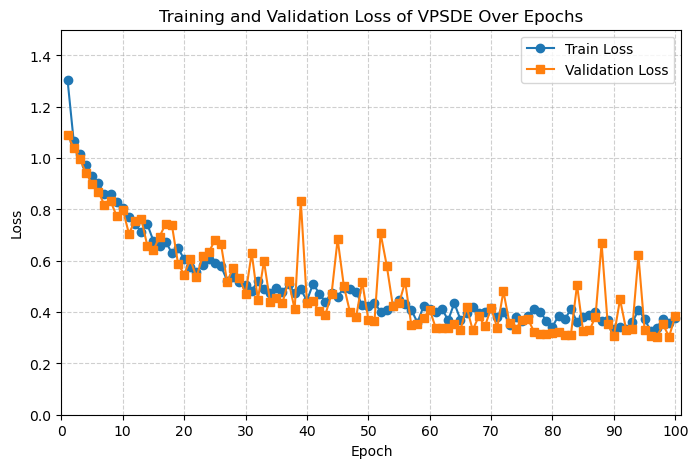

In [20]:
import matplotlib.pyplot as plt


epochs = list(range(1, len(all_losses_train) + 1))


plt.figure(figsize=(8, 5))
plt.plot(epochs, all_losses_train, label="Train Loss", marker="o", linestyle="-")
plt.plot(epochs, all_losses_valid, label="Validation Loss", marker="s", linestyle="-")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss of VPSDE Over Epochs")
plt.ylim(0, 1.5)
plt.xlim(0,101)
plt.xticks(range(0, 101, 10))
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()